## Making the study area

To employ the internal Rossby radius of deformation to limit the study area, I have decided to try the following:
- Make a polygon around the wind park by finding minimum and maximum of lon/lat in the coordinates. Aka least-fit square.
- Then add X times the Rossby radius in all directions. Choice of X depends on what it looks like. I want to make X big enough such that the wind wake is within.
- I will choose the mean Rossby radius of June to be the value 'to add on'. This is because I would like to make sure that the largest eddies are also seen. 
- Below I'm testing this approach on Sørvest-F and Nordvest-C to see if the method works and looks reasonable.

In [1]:
from Rossby_deformation.get_turbine_coords import get_turbine_coords
from Rossby_deformation.funcs import *

import matplotlib.style as mplstyle
import cartopy.feature as cfeature

mplstyle.use(['ggplot', 'fast'])

%load_ext autoreload
%autoreload 2

In [2]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [3]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [4]:
nordvest_C = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Nordvest_C.txt')

In [5]:
lon = grid.lon_rho
lat = grid.lat_rho

In [6]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/lustre/storeB/project/nwp/havvind/hav/analysis_kjsta/output_bdr/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [7]:
# Square around wind park
min_lon_SV = np.min(sorvest_F.coordinates[:,0].values)
min_lat_SV = np.min(sorvest_F.coordinates[:,1].values)
max_lon_SV = np.max(sorvest_F.coordinates[:,0].values)
max_lat_SV = np.max(sorvest_F.coordinates[:,1].values)

area_lon_SV = [min_lon_SV, max_lon_SV]
area_lat_SV = [min_lat_SV, max_lat_SV]

In [8]:
min_lon_NV = np.min(nordvest_C.coordinates[:,0].values)
min_lat_NV = np.min(nordvest_C.coordinates[:,1].values)
max_lon_NV = np.max(nordvest_C.coordinates[:,0].values)
max_lat_NV = np.max(nordvest_C.coordinates[:,1].values)

area_lon_NV = [min_lon_NV, max_lon_NV]
area_lat_NV = [min_lat_NV, max_lat_NV]

In [9]:
# Getting the monthly mean of R1 of the area
# The mean of June will be the distance added to expand to study area
R1_mon_mean_SV = monthly_mean_area(files, grid, area_lon_SV, area_lat_SV)
R1_mon_mean_NV = monthly_mean_area(files, grid, area_lon_NV, area_lat_NV)

R1_june_SV = R1_mon_mean_SV.gamma_r[-1]
R1_june_NV = R1_mon_mean_NV.gamma_r[-1]

## Approach 1:
Masking

In this method I expand the box around the windpark with 25 times the June internal Rossby radius in each direction. The resulting study area is then $50R_1$ x $50R_1$ m² large. The internal Rossby radius is calculated by taking the horizontal mean of the blue box. I chose to use the value of June to capture the largest structures.

From Christensen et al.(2022) it is clear that the impacts of wind farms can extend quite far, and so if using the Rossby radius as a measure the extended study area should be relatively large.

In [10]:
exp_SV_lon, exp_SV_lat, exp_SV = make_study_area(files, grid, area_lon_SV, area_lat_SV, R1_june_SV)

In [11]:
exp_NV_lon, exp_NV_lat, exp_NV = make_study_area(files, grid, area_lon_NV, area_lat_NV, R1_june_NV)

In [12]:
ds_monthly = monthly_mean(files)

In [15]:
exp_SV

<xarray.Dataset>
Dimensions:     (ocean_time: 149, eta_rho: 217, xi_rho: 222)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-02-02T12:00:00 ... 2022-06-3...
    lon_rho     (eta_rho, xi_rho) float64 5.631 5.636 5.641 ... 4.295 4.3 4.306
    lat_rho     (eta_rho, xi_rho) float64 55.85 55.86 55.87 ... 57.9 57.91 57.92
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    bvf         (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 217, 222), meta=np.ndarray>
    gamma_r     (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 217, 222), meta=np.ndarray>

Text(0.5, 0.98, 'Study area - Sørvest-F')

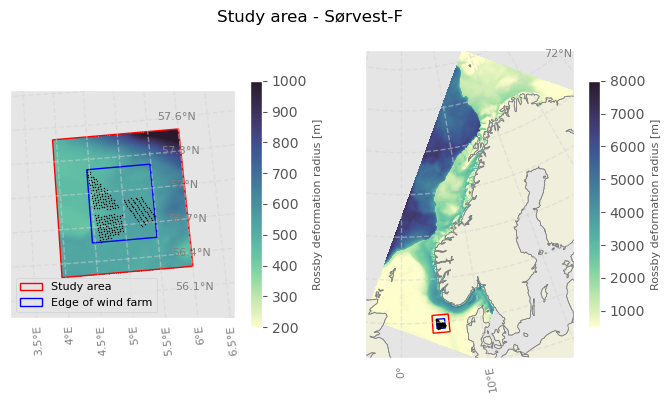

In [21]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(exp_SV.lon_rho, exp_SV.lat_rho, exp_SV.gamma_r.mean(dim='ocean_time')[:, :], 
                       transform=ccrs.PlateCarree(), cmap=cmap, vmin=200, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

pl = ax[1].pcolormesh(lon, lat, ds_monthly.mean(dim='ocean_time').gamma_r[:,:], 
                      transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

area_lon = [np.min(exp_SV_lon), np.max(exp_SV_lon), np.max(exp_SV_lon), np.min(exp_SV_lon)]
area_lat = [np.min(exp_SV_lat), np.min(exp_SV_lat), np.max(exp_SV_lat), np.max(exp_SV_lat)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1, label='Study area')
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(sorvest_F.coordinates[:, 0]), np.max(sorvest_F.coordinates[:, 0]), 
         np.max(sorvest_F.coordinates[:, 0]), np.min(sorvest_F.coordinates[:, 0])]
w_lat = [np.min(sorvest_F.coordinates[:, 1]), np.min(sorvest_F.coordinates[:, 1]), 
         np.max(sorvest_F.coordinates[:, 1]), np.max(sorvest_F.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1, label='Edge of wind farm')
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=0.5) 
    
    gl = axs.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1,
        color="lightgray",
        alpha=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xlabel_style = {'color': 'gray', 'fontsize': 8}  # Color for longitude labels
    gl.ylabel_style = {'color': 'gray', 'fontsize': 8}

# Adding land, coastline, and borders
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)


ax[0].legend(fontsize=8)

fig.suptitle('Study area - Sørvest-F')

Text(0.5, 0.98, 'Study area - Nordvest-C')

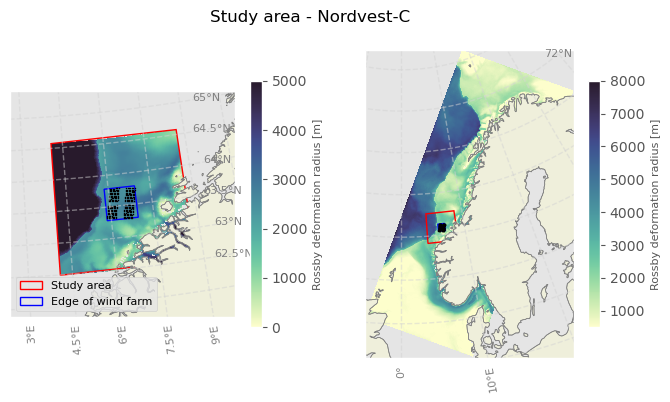

In [22]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(exp_NV.lon_rho, exp_NV.lat_rho, exp_NV.mean(dim='ocean_time').gamma_r[:, :], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=5000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

pl = ax[1].pcolormesh(lon, lat, ds_monthly.mean(dim='ocean_time').gamma_r[:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

area_lon = [np.min(exp_NV_lon), np.max(exp_NV_lon), np.max(exp_NV_lon), np.min(exp_NV_lon)]
area_lat = [np.min(exp_NV_lat), np.min(exp_NV_lat), np.max(exp_NV_lat), np.max(exp_NV_lat)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1, label='Study area')
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(nordvest_C.coordinates[:, 0]), np.max(nordvest_C.coordinates[:, 0]), 
         np.max(nordvest_C.coordinates[:, 0]), np.min(nordvest_C.coordinates[:, 0])]
w_lat = [np.min(nordvest_C.coordinates[:, 1]), np.min(nordvest_C.coordinates[:, 1]), 
         np.max(nordvest_C.coordinates[:, 1]), np.max(nordvest_C.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1, label='Edge of wind farm')
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[i][0], nordvest_C.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=0.5) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xlabel_style = {'color': 'gray', 'fontsize': 8}  # Color for longitude labels
    gl.ylabel_style = {'color': 'gray', 'fontsize': 8}

ax[0].legend(fontsize=8)

# Adding land, coastline, and borders
land0 = cfeature.NaturalEarthFeature(category='physical', name='land', scale='10m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline0 = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='10m', edgecolor='gray', facecolor='none')

land1 = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline1 = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')

ax[0].add_feature(land0)
ax[0].add_feature(coastline0)

ax[1].add_feature(land1)
ax[1].add_feature(coastline1)


fig.suptitle('Study area - Nordvest-C')

## Approach 2:
slicing and interpolating

In [15]:
lon2d, lat2d, R1_SV = v2_make_region_dataset(files[0], grid, area_lon_SV, area_lat_SV, R1_june_SV)

Text(0.5, 0.98, 'Study area - Sørvest-F')

/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


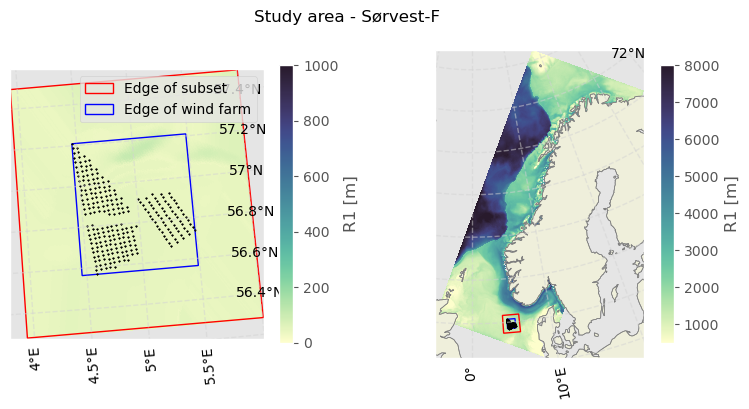

In [16]:
proj=ccrs.NorthPolarStereo()
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})

cmap = 'cmo.deep'

pll = ax[0].pcolormesh(lon2d, lat2d, R1_SV[:, :], transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, ds_monthly.gamma_r[-1,:,:], transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [np.min(lon2d), np.max(lon2d), np.max(lon2d), np.min(lon2d)]
area_lat = [np.min(lat2d), np.min(lat2d), np.max(lat2d), np.max(lat2d)]

ax[0].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1, label='Edge of subset')
ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

w_lon = [np.min(sorvest_F.coordinates[:, 0]), np.max(sorvest_F.coordinates[:, 0]), 
         np.max(sorvest_F.coordinates[:, 0]), np.min(sorvest_F.coordinates[:, 0])]
w_lat = [np.min(sorvest_F.coordinates[:, 1]), np.min(sorvest_F.coordinates[:, 1]), 
         np.max(sorvest_F.coordinates[:, 1]), np.max(sorvest_F.coordinates[:, 1])]

ax[0].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1, label='Edge of wind farm')
ax[1].fill(w_lon, w_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='blue', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

ax[0].legend()

for axs in ax.flatten():
    axs.add_feature(land)
    axs.add_feature(coastline)

fig.suptitle('Study area - Sørvest-F')

### Summary and thoughts

Based on the above trial and errors I will move forward with making a study area using the masked method. The slicing and interpolation would to me seem like unnecessary tampering of the data. The logic and code of the masking method is also nicer.

So in the further analysis of the actual impacts of the wind farms on the upper ocean I will make a study area around the farms measuring $50R_1$ x $50R_1$ of the areas mean internal Rossby radius of June.

Using a smaller region would to me seem non-beneficial as other papers have shown impacts on the ocean over a larger extent than what $10R_1$ x $10R_1$ would show us (Kai first suggested using 4-7 x R1). The study area is made by expanding the square around the wind farm with the same distance in all directions. To me this is reasonable as the wind wake depends on direction of winds and it would be benefical to be able to capture special cases as well, not just the mean wind direction. 

# Investigating the baroclinic Rossby deformation radius of the study area

In [34]:
exp = xr.open_mfdataset(files)
exp = convert_ocean_time(exp)

In [35]:
exp_mon = exp.resample(ocean_time="1M").mean(dim="ocean_time")
exp_SV_mon = exp_SV.resample(ocean_time="1M").mean(dim="ocean_time")
exp_NV_mon = exp_NV.resample(ocean_time="1M").mean(dim="ocean_time")

In [ ]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(3, 5, figsize=(20, 10), subplot_kw={'projection': proj})

plt.subplots_adjust(wspace=0.5)

cmap1 = 'cmo.deep'
cmap2 = 'cmo.deep'
vmin1 = 20
vmax1 = 2000
vmin2 = 20
vmax2 = 10000


for i in range(5):
    axs = ax[0, i]
    axs.set_extent([exp_SV_lon[0], exp_SV_lon[1], exp_SV_lat[0], exp_SV_lat[1]])
    
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Plot pcolormesh
    plot = axs.pcolormesh(exp_SV_mon.lon_rho, exp_SV_mon.lat_rho, exp_SV_mon.gamma_r[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap1,
                          vmin=vmin1, vmax=vmax1)
    axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=9)

cbar = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

for i in range(5):
    axs = ax[1, i]
    axs.set_extent([exp_NV_lon[0], exp_NV_lon[1], exp_NV_lat[0], exp_NV_lat[1]])
    
    for j in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[j][0], nordvest_C.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Plot pcolormesh
    plot = axs.pcolormesh(exp_NV.lon_rho, exp_NV_mon.lat_rho, exp_NV_mon.gamma_r[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap1,
                          vmin=vmin1, vmax=vmax1)
    #axs.set_title(['February', 'March', 'April', 'May', 'June'][i], fontsize=9)

cbar = fig.colorbar(plot, ax=ax[0], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)


for i in range(5):
    axs = ax[2, i]
    
    # Plot coordinates
    for j in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[j][0], sorvest_F.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
        
    for j in range(len(nordvest_C.coordinates)):
        axs.plot(nordvest_C.coordinates[j][0], nordvest_C.coordinates[j][1], 
                 transform=ccrs.PlateCarree(), color='black', marker='*', markersize=1)
    
    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                       color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'fontsize': 8, 'color':'gray'}
    gl.ylabel_style = {'fontsize': 8, 'color':'gray'}

    # Plot pcolormesh
    plot = axs.pcolormesh(exp_mon.gamma_r[i, :, :], 
                          transform=ccrs.PlateCarree(), cmap=cmap2,
                          vmin=vmin2, vmax=vmax2)

    land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
    coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')
    
    axs.add_feature(land)
    axs.add_feature(coastline)


cbar = fig.colorbar(plot, ax=ax[1], orientation='vertical', shrink=0.8, aspect=10)
cbar.set_label('Rossby deformation radius [m]', fontsize=8)

fig.suptitle('Monthly mean EXP', y=0.95)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fef07dfa280> (for post_execute):


KeyboardInterrupt: 